In [1]:
from matplotlib import pyplot as plt
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix 
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import model_from_json
from keras.utils import multi_gpu_model 
from keras.utils import to_categorical


Using TensorFlow backend.


Read the data
===========

In [2]:
x_original=pd.read_csv('_xlable4_withNa_AllColumns.txt')
y_original=pd.read_csv('_targelable4_withNa_AllColumns.txt')

# x_original=x_original[['Unnamed: 0','S000502', 'S000501', 'S000300', 'L190400', 'L190500', 'L190300', 'SEX',
#                        'L100700', 'L103000', 'L103300', 'L100800', 'L101700', 'AGE', 'L100500', 'L101300',
#                        'S000100', 'L102900','FIELD_33', 'FIELD_38', 'FIELD_7', 'FIELD_29', 'FIELD_27', 'FIELD_6',
#                        'FIELD_40', 'FIELD_41', 'FIELD_28', 'FIELD_42', 'FIELD_19']]

# y_original=y_original[['Unnamed: 0','S000502', 'S000501', 'S000300', 'L190400', 'L190500', 'L190300', 'SEX',
#                        'L100700', 'L103000', 'L103300', 'L100800', 'L101700', 'AGE', 'L100500', 'L101300',
#                        'S000100', 'L102900','FIELD_33', 'FIELD_38', 'FIELD_7', 'FIELD_29', 'FIELD_27', 'FIELD_6',
#                        'FIELD_40', 'FIELD_41', 'FIELD_28', 'FIELD_42', 'FIELD_19']]

x_original=x_original[['Unnamed: 0','S000502', 'S000501', 'S000300', 'L190400', 'L190500', 'L190300', 'SEX',
                       'L100700', 'L103000', 'L103300', 'L100800', 'L101700', 'AGE', 'L100500', 'L101300'
                       ]]

y_original=y_original[['Unnamed: 0','S000502']]


print(x_original.shape)
print(y_original.shape)


(159381, 16)
(159381, 2)


In [3]:
for index,col in enumerate(x_original.columns):
    print(col,x_original[col].dropna().shape[0])

Unnamed: 0 159381
S000502 159305
S000501 159305
S000300 159075
L190400 159241
L190500 159204
L190300 159204
SEX 159381
L100700 152474
L103000 158939
L103300 135222
L100800 159236
L101700 158951
AGE 159381
L100500 158954
L101300 159247


Prepare the data
============

In [4]:
df=x_original.copy()
conditions = [
    (df.S000501 < 120)  ,
    (df.S000501 >= 120) & (df.S000501 < 130),
    (df.S000501 >=130)]
choices = [0,1,2]
df['sbpG'] = np.select(conditions, choices, default=0)
df.head()
x_original=df.copy()

conditions2 = [
    (df.S000502 < 80)  ,
    (df.S000502 >= 80) & (df.S000502 < 90),
    (df.S000502 >=90)]
choices2 = [0,1,2]
df['dbpG'] = np.select(conditions2, choices2, default=0)
df.head()
x_original=df.copy()

conditions3 = [
    (df.AGE < 30)  ,
    (df.AGE >= 30) & (df.AGE < 40),
    (df.AGE >= 40) & (df.AGE < 50),
    (df.AGE >= 50) & (df.AGE < 60),
    (df.AGE >= 60)]
choices3 = [0,1,2,3,4]
df['AgeG'] = np.select(conditions3, choices3, default=0)
df.head()
x_original=df.copy()


conditions4 = [
    (df.L100800 < 100)  ,
    (df.L100800 >= 100) & (df.L100800 < 126), 
    (df.L100800 >= 126)]
choices4 = [0,1,2]
df['CLASS'] = np.select(conditions4, choices4, default=0)
df.head()
x_original=df.copy()

In [69]:
data= pd.merge(x_original,y_original, how='inner',left_on='Unnamed: 0', right_on='Unnamed: 0')
data=data.dropna(). reset_index()

# data=data[data.AGE_x >= 40]
# data=data[data.AGE_x < 50]

# data=data[data.CLASS_x==0]
# data=data[data.sbpG==0]
# data=data[data.dbpG==0]

# data=data[data.L100800_y <200]

print(data.shape)

(129059, 22)


In [70]:
print(data.shape)
print(data.columns)
data.head()

(129059, 22)
Index(['index', 'Unnamed: 0', 'S000502_x', 'S000501', 'S000300', 'L190400',
       'L190500', 'L190300', 'SEX', 'L100700', 'L103000', 'L103300', 'L100800',
       'L101700', 'AGE', 'L100500', 'L101300', 'sbpG', 'dbpG', 'AgeG', 'CLASS',
       'S000502_y'],
      dtype='object')


,index,Unnamed: 0,S000502_x,S000501,S000300,L190400,L190500,L190300,SEX,L100700,...,L100800,L101700,AGE,L100500,L101300,sbpG,dbpG,AgeG,CLASS,S000502_y
0,0,0,67.0,121.0,20.1,12.3,38.2,4.20,1.0,3.0,...,77.0,13.0,44.0,0.8,8.0,1,0,2,0,76.0
1,1,1,76.0,117.0,19.7,13.1,39.0,4.24,1.0,3.0,...,89.0,14.0,45.0,0.8,9.0,0,0,2,0,82.0
2,2,2,82.0,135.0,20.2,12.9,38.4,4.26,1.0,3.8,...,78.0,15.0,46.0,0.8,10.0,2,1,2,0,78.0
3,3,3,71.0,118.0,24.8,13.5,40.3,4.20,1.0,3.7,...,95.0,10.0,51.0,0.8,12.0,0,0,3,0,65.0
4,4,4,65.0,111.0,25.5,12.6,38.6,3.92,1.0,3.4,...,90.0,12.0,52.0,0.8,12.0,0,0,3,0,65.0


In [71]:
# x=data[['S000502_x', 'S000501_x', 'S000300_x', 'L190400_x', 'L190500_x', 'L190300_x', 'SEX_x',
#                        'L100700_x', 'L103000_x', 'L103300_x', 'L100800_x', 'L101700_x', 'AGE_x', 'L100500_x', 'L101300_x',
#                        'S000100_x', 'L102900_x','FIELD_33_x', 'FIELD_38_x', 'FIELD_7_x', 'FIELD_29_x', 'FIELD_27_x', 'FIELD_6_x',
#                        'FIELD_40_x', 'FIELD_41_x', 'FIELD_28_x', 'FIELD_42_x', 'FIELD_19_x',
#         'CLASS','sbpG','dbpG','AgeG']]

# y=data[['S000502_y', 'S000501_y', 'S000300_y', 'L190400_y', 'L190500_y', 'L190300_y', 'SEX_y',
#                        'L100700_y', 'L103000_y', 'L103300_y', 'L100800_y', 'L101700_y', 'AGE_y', 'L100500_y', 'L101300_y',
#                        'S000100_y', 'L102900_y','FIELD_33_y', 'FIELD_38_y', 'FIELD_7_y', 'FIELD_29_y', 'FIELD_27_y', 'FIELD_6_y',
#                        'FIELD_40_y', 'FIELD_41_y', 'FIELD_28_y', 'FIELD_42_y', 'FIELD_19_y'
#         ]]

x=data[['S000502_x', 'S000501', 'S000300', 'L190400', 'L190500', 'L190300', 'SEX',
                       'L100700', 'L103000', 'L103300', 'L100800', 'L101700', 'AGE', 'L100500', 'L101300']]

y=data[['S000502_y']]

Check the correlation of the selected feature with the independent variables
=====

In [72]:
temppd=pd.DataFrame(x.copy())
temppd['y']=y.S000502_y
temppd.head()
corval=abs(temppd.corr()).sort_values(by='y', ascending=False)

In [73]:
corval.y

y            1.000000
S000502_x    0.587135
S000501      0.576698
S000300      0.371655
SEX          0.332026
L190400      0.327824
L190300      0.322543
L190500      0.318169
L100700      0.310325
L103300      0.268800
L103000      0.258139
L101700      0.245664
L100500      0.245534
L100800      0.241453
L101300      0.218401
AGE          0.167756
Name: y, dtype: float64

In [74]:
#histogram plot of the features
# import matplotlib.pyplot as plt
# x[x.dtypes[(x.dtypes=="float64")|(x.dtypes=="int64")]
#                         .index.values].hist(figsize=[11,11])

Apply PCA
===========

In [75]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=8)
# pca.fit(x)

# print(pca.explained_variance_ratio_)   
# print(np.sum(pca.explained_variance_ratio_))

# x=pca.fit_transform(x) 
# print(x.shape)


feature scaling
=======

In [76]:
# from sklearn import preprocessing
# min_max_scaler_x = preprocessing.StandardScaler()  #MinMaxScaler()
# min_max_scaler_y = preprocessing.StandardScaler()  #MinMaxScaler()
# x = min_max_scaler_x.fit_transform(x)

clustring test
==========

In [77]:
# from sklearn.cluster import KMeans
# from scipy.spatial.distance import cdist

# K = range(1,10)
# distortions = []

# for k in K:
#     kmeanModel = KMeans(n_clusters=k).fit(x)
#     kmeanModel.fit(x)
#     distortions.append(sum(np.min(cdist(x, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / x.shape[0])

# # Plot the elbow
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()


In [78]:
# kmeanModel = KMeans(n_clusters=k).fit(x)
# x['lbl']=kmeanModel.labels_ 

In [79]:
# x.columns

Random Forest Regressor
=============

In [80]:
ylable=y[['S000502_y']]  
# ylable=min_max_scaler_y.fit_transform(ylable)
# ylable=pd.DataFrame(ylable,columns=['S000502_y'])

xtrain,xtest,ytrain,ytest=train_test_split(x, ylable, random_state=42, test_size=0.2)

In [81]:
regr = RandomForestRegressor(max_depth=7, random_state=0,verbose =0,n_estimators=300,warm_start=True)
regr.fit(xtrain, ytrain) 
print(regr.feature_importances_)
ypred=regr.predict(xtest)


[6.26846871e-01 2.79041295e-01 1.95416627e-02 2.37824109e-03
 1.14110911e-03 2.81328299e-03 2.50576817e-02 2.57650627e-03
 2.97083890e-03 1.47977112e-03 1.28397252e-03 2.27335723e-02
 1.04561786e-02 3.29468232e-04 1.34954860e-03]


mean_squared_error 48.9413331950274
root mean_squared_error 6.9958082588809845
mean_absolute_error 5.6197121722153565
r2_score 0.4206390732275308


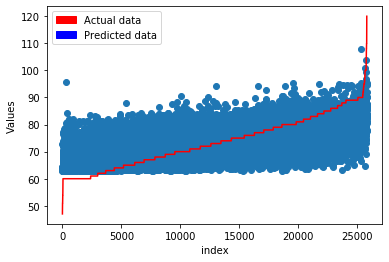

,t + 1,pred (t +1)
6839,110.0,83.887587
6884,111.0,77.637738
15888,111.0,87.465425
2337,112.0,82.893456
2296,113.0,83.437623
1328,113.0,87.414067
4294,115.0,85.458912
10329,120.0,85.805635
16840,120.0,90.278806
2050,120.0,77.923759


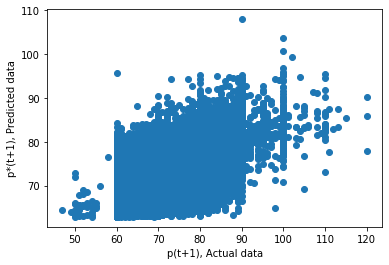

In [82]:

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(30)

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.tail(10)

In [101]:
ypredPD['valDiff']=abs(ypredPD['t + 1'] - ypredPD['pred (t +1)']).astype(float)
print('mean',np.mean(ypredPD.valDiff))
print('std',np.std(ypredPD.valDiff))

print('<= 5',100*ypredPD.valDiff[ypredPD.valDiff<=5].shape[0]/ypredPD.shape[0])
print('<= 10',100*ypredPD.valDiff[ypredPD.valDiff<=10].shape[0]/ypredPD.shape[0])
print('<= 15',100*ypredPD.valDiff[ypredPD.valDiff<=15].shape[0]/ypredPD.shape[0])


ypredPD.head()

mean 5.619712172215367
std 4.16655352737511
<= 5 51.66201766620177
<= 10 85.42150937548428
<= 15 96.98977219897722


,t + 1,pred (t +1),diff,valDiff
15383,47.0,64.396415,17.396415,17.396415
10419,49.0,63.938023,14.938023,14.938023
23711,50.0,63.974421,13.974421,13.974421
2109,50.0,72.967983,22.967983,22.967983
11018,50.0,62.923496,12.923496,12.923496


In [99]:

# ypredPD.diff[]
# ypredPD.valDiff

51.66201766620177


In [84]:
# tempdata=pd.DataFrame(xtest.copy())
# tempdata['ytest']=ytest
# # temp=temp.dropna()
# # tempdata.head()
# # tempdata[tempdata.ytest.isna()].index

# tempdata=tempdata.drop(tempdata[tempdata.ytest.isna()].index)


xg boost
==========

In [62]:
import xgboost as xgb
# from sklearn.metrics import mean_squared_error
# import pandas as pd
# import numpy as np

In [63]:
xg_reg = xgb.XGBRegressor()
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, 
#                           learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(xtrain, ytrain) 

[13:22:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [64]:

ypred = xg_reg.predict(xtest)

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

# ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
# ypredPD['t + 1']=ytest.values
# ypredPD['pred (t +1)']=ypred
# ypredPD.head(10)

mean_squared_error 0.5779223231863916
root mean_squared_error 0.7602120251524516
mean_absolute_error 0.6100429289592354
r2_score 0.42597181844508347


In [41]:
# ytest[ytest.isna()].shape
# tempdata.iloc[:,-1]

ANN
==========

In [38]:
model= Sequential()
model.add(Dense(input_dim=32,units=128,activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=128, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=64, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=32, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=16, activation='relu', kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=8, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=1, kernel_initializer='uniform'))
model.compile(loss='mean_squared_error', optimizer='Nadam', metrics=['mean_squared_error' ])

In [39]:
h=model.fit(xtrain, ytrain, validation_split=.2,epochs=100, batch_size=50)

Train on 23081 samples, validate on 5771 samples
Epoch 1/100
23081/23081 [==============================] - 2s 67us/step - loss: 1685.2696 - mean_squared_error: 1685.2696 - val_loss: 130.0532 - val_mean_squared_error: 130.0532
Epoch 2/100
23081/23081 [==============================] - 1s 31us/step - loss: 267.1356 - mean_squared_error: 267.1356 - val_loss: 64.9673 - val_mean_squared_error: 64.9673
Epoch 3/100
23081/23081 [==============================] - 1s 32us/step - loss: 286.2935 - mean_squared_error: 286.2935 - val_loss: 133.5067 - val_mean_squared_error: 133.5067
Epoch 4/100
23081/23081 [==============================] - 1s 31us/step - loss: 155.4325 - mean_squared_error: 155.4325 - val_loss: 2245.0856 - val_mean_squared_error: 2245.0856
Epoch 5/100
23081/23081 [==============================] - 1s 31us/step - loss: 143.3802 - mean_squared_error: 143.3802 - val_loss: 45.7587 - val_mean_squared_error: 45.7587
Epoch 6/100
23081/23081 [==============================] - 1s 31us/step

Epoch 48/100
23081/23081 [==============================] - 1s 34us/step - loss: 44.2245 - mean_squared_error: 44.2245 - val_loss: 41.6533 - val_mean_squared_error: 41.6533
Epoch 49/100
23081/23081 [==============================] - 1s 34us/step - loss: 44.2098 - mean_squared_error: 44.2098 - val_loss: 39.7779 - val_mean_squared_error: 39.7779
Epoch 50/100
23081/23081 [==============================] - 1s 35us/step - loss: 43.9036 - mean_squared_error: 43.9036 - val_loss: 40.1667 - val_mean_squared_error: 40.1667
Epoch 51/100
23081/23081 [==============================] - 1s 34us/step - loss: 43.7038 - mean_squared_error: 43.7038 - val_loss: 40.5862 - val_mean_squared_error: 40.5862
Epoch 52/100
23081/23081 [==============================] - 1s 34us/step - loss: 44.2443 - mean_squared_error: 44.2443 - val_loss: 41.3574 - val_mean_squared_error: 41.3574
Epoch 53/100
23081/23081 [==============================] - 1s 33us/step - loss: 43.9789 - mean_squared_error: 43.9789 - val_loss: 43.3

In [40]:
ypred=model.predict(xtest)

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)

mean_squared_error 45.454461256635625
root mean_squared_error 6.7419923803454145
mean_absolute_error 5.555490631014666
r2_score 0.33439692565685286


,t + 1,pred (t +1)
0,81.0,71.246559
1,71.0,72.241997
2,76.0,71.153358
3,70.0,72.481361
4,80.0,81.199577
5,73.0,75.336769
6,60.0,67.529060
7,68.0,71.162544
8,74.0,72.666443
9,65.0,76.278847


dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


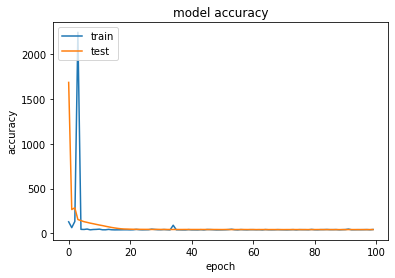

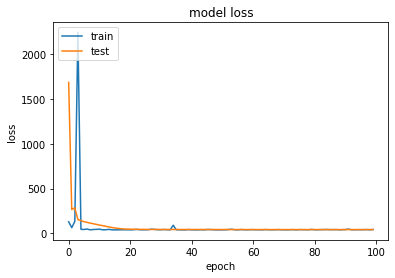

In [41]:
history=h
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['mean_squared_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
ypredPD['diff']=abs(ypredPD['t + 1']- ypredPD['pred (t +1)'])
print(np.mean(ypredPD['diff']))
print(np.std(ypredPD['diff']))
print(100*ypredPD[ypredPD['diff']<=5].shape[0]/ypredPD.shape[0])

5.555490631014666
3.819814799874982
48.75918480521281


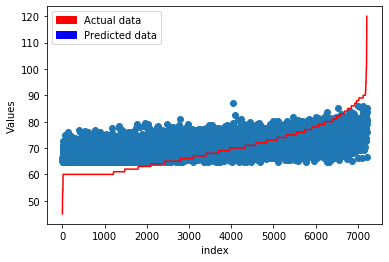

,t + 1,pred (t +1),diff
1126,45.0,65.120796,20.120796
6934,49.0,66.304474,17.304474
775,51.0,65.990448,14.990448
2176,51.0,66.686180,15.686180
5433,52.0,65.534470,13.534470
5689,53.0,66.345856,13.345856
5412,53.0,64.553864,11.553864
819,53.0,64.526611,11.526611
5655,54.0,67.312355,13.312355
1344,54.0,69.152115,15.152115


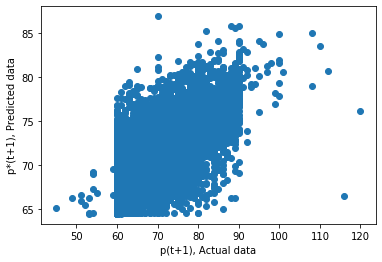

In [43]:

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.head(10)

SVR
======

In [ ]:
from sklearn.svm import SVR
# svr_rbf = SVR(kernel='rbf', C=10, gamma=0.02, epsilon=.001)
svr_rbf = SVR(kernel='rbf')

In [ ]:
svr_rbf.fit(xtrain, ytrain) 

In [ ]:
ypred=svr_rbf.predict(xtest)

In [ ]:
import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)